In [52]:
import numpy as np

import jax
from jax import jit
import jax.numpy as jnp
from jax import grad, random, vmap
from jax.lax.linalg import triangular_solve
import optax

import math

import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

from utils import *
from kernels import * 

import wandb


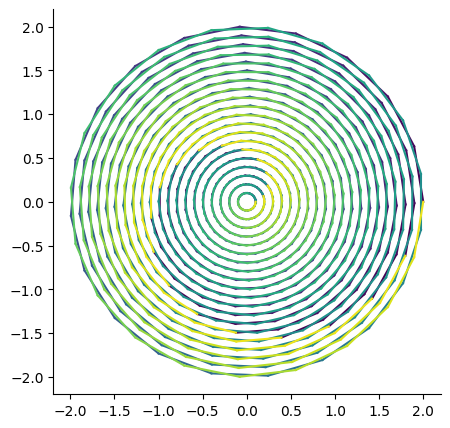

In [6]:
num_trajectories = 20
time_steps = 40

time = jnp.linspace(0, 4 *jnp.pi, time_steps)[:, jnp.newaxis]
radii = jnp.linspace(0.1, 2, num_trajectories)
phases = jnp.linspace(0, 2*jnp.pi, num_trajectories)

sine_waves = jnp.sin(time + phases) * radii
cosine_waves = jnp.cos(time + phases) * radii

X = jnp.stack([cosine_waves.T, sine_waves.T], axis=1)   #K=50, N=2, T=200
K, N, T = X.shape

A = jnp.swapaxes(X, 0, 1)                  #(N, K, T)
A = A.reshape(N,-1)                        #(N, K*T)

key = random.PRNGKey(41)
c = 10
indices = jax.random.choice(key, A.shape[1], shape=(c,), replace=False)
u = A[:, indices]                         #(N, c)


plot_2D(X)

In [11]:
K_A_u =  K_X_Y_squared_exponential(A, u)               #(K*T, c)
K_u_u =  K_X_Y_squared_exponential(u, u)               #(c, c)
K_A_A = K_A_u @ K_u_u @ K_A_u.T
L = jnp.linalg.cholesky(K_u_u + jnp.identity(c) * 1e-6)
K_u_u_inv = triangular_solve(K_u_u, jnp.eye(K_u_u.shape[0]))
#K_u_u_inv = jnp.linalg.inv(K_u_u)
K_u_u_inv

Array([[ 1.0000000e+00, -3.3378854e-02, -2.6368219e-02, ...,
         1.5444285e-03, -2.2229750e-04, -2.9359448e-03],
       [ 0.0000000e+00,  1.0000000e+00, -2.8031287e-01, ...,
         5.2441815e-03,  1.3774731e-03,  1.1147677e-03],
       [ 0.0000000e+00,  0.0000000e+00,  1.0000000e+00, ...,
        -5.1656943e-03,  2.7225304e-03,  1.3401675e-03],
       ...,
       [ 0.0000000e+00,  0.0000000e+00,  0.0000000e+00, ...,
         1.0000000e+00, -8.8164687e-01, -1.3575077e-02],
       [ 0.0000000e+00,  0.0000000e+00,  0.0000000e+00, ...,
         0.0000000e+00,  1.0000000e+00, -6.1092067e-01],
       [ 0.0000000e+00,  0.0000000e+00,  0.0000000e+00, ...,
         0.0000000e+00,  0.0000000e+00,  1.0000000e+00]], dtype=float32)

In [44]:
def get_params(params):
    alpha_tilde = params['alpha_tilde']
    l_tilde = params['l_tilde']  
    #sigma_f_tilde = params['sigma_f_tilde'] 
    
    l = jnp.exp(l_tilde)
    #sigma_f = jnp.exp(sigma_f_tilde)
    #l = 1
    sigma_f = 1
    return alpha_tilde, l, sigma_f

def get_alpha(params, A, X, u, kernel_function):
    K, N, T = X.shape
    c = u.shape[-1]
    #l = 1
    sigma_f = 1

    alpha_tilde, l, sigma_f = get_params(params)

    # #Inducing points
    K_A_u =  kernel_function(A, u, l=l, sigma_f=sigma_f)                 #(K*T, c)
    #centering here? 
    K_A_u_reshaped = K_A_u.reshape(K,T,c)                                #(K, T, c)
    mean = jnp.mean(K_A_u_reshaped, axis=(0), keepdims=True)             #(1, T, c)
    H_K_A_u = (K_A_u_reshaped - mean).reshape(K*T,c)                     #(K*T,c)
    K_u_u =  kernel_function(u, u, l=l, sigma_f=sigma_f)                 #(c, c)
    #K_A_A = jnp.einsum('kc,cj,mj ->km',  H_K_A_u, jnp.linalg.inv(K_u_u), H_K_A_u)       #K_A_u @ K_u_u @ K_A_u.T (K*T, K*T)
    L = jnp.linalg.cholesky(K_u_u + jnp.identity(c) * 1e-6)
    Q, R = jnp.linalg.qr(H_K_A_u, mode='reduced')                                                                                        #(mode reduced Q(kt, c) R(c,c) versus complete Q (kt,kt) and R(KT, c))
    alpha_tilde_QR, _ = jnp.linalg.qr(alpha_tilde) 
    alpha = jnp.einsum('kc, cl, lj, jd -> kd', Q, triangular_solve(R.T, jnp.eye(R.shape[0]), lower=True), L, alpha_tilde_QR) #(K*T, c) @ (c, c) @ (c, c) @ (c, d)

    return alpha, K_A_u, K_u_u, H_K_A_u

def single_pair_loss(alpha_H, u, params, kernel_function, K_A_u, K_u_u, id_1, id_2, operator = 'minus'):

    _, l, sigma_f = get_params(params)
    #l = 1
    sigma_f = 1
  
    K_u_X_i =  kernel_function(u, X[id_1], l=l, sigma_f=sigma_f)                              #(c, K, T)
    K_X_u_i =  kernel_function(u, X[id_2], l=l, sigma_f=sigma_f).T

    #K_u_u_inv = triangular_solve(K_u_u, jnp.eye(K_u_u.shape[0]))
    K_u_u_inv = jnp.linalg.inv(K_u_u)

    K_A_X_i = jnp.einsum('kc,cj,jm ->km',  K_A_u, K_u_u_inv, K_u_X_i) 
    K_X_A_i = jnp.einsum('kc,cj,mj ->km',  K_X_u_i, K_u_u_inv, K_A_u) 

    # K_A_X_i = kernel_function(A, X[id_1], l=l, sigma_f=sigma_f)
    # K_X_A_i = kernel_function(A, X[id_2], l=l, sigma_f=sigma_f).T
                  
    Q = jnp.einsum('kd,kt,tj,jm->dm', alpha_H, K_A_X_i, K_X_A_i, alpha_H)    #(KT,D).T @ (KT,T) and (T,KT) @ (KT,D) --> (D,T) @ (T,D) --> (D,D)
    QQ_product = Q @ Q                                                       # jnp.einsum('ij,jm->im', Q, Q)

    if operator == 'minus':
        return jnp.trace(Q)**2 - jnp.trace(QQ_product)
    
    elif operator == 'plus':
        return jnp.trace(Q)**2 + jnp.trace(QQ_product)
 

def loss(params, X, A, u, d,kernel_function, key, normalized = False):  
    K, N, T = X.shape

    alpha, K_A_u, K_u_u, _ = get_alpha(params, A, X, u, kernel_function)

    #!!! centering of alpha!
    alpha_reshaped = alpha.reshape(K,T,d)                           #(K, T, D)
    mean = jnp.mean(alpha_reshaped, axis=(0), keepdims=True)        #(1, T, D)
    alpha_H = (alpha_reshaped - mean).reshape(K*T,d)                #(K*T,D)

    num_pairs = 100  
    indices = random.randint(key, shape=(num_pairs*2,), minval=0, maxval=K) 
    index_pairs = indices.reshape((num_pairs, 2))

    batched_loss = vmap(single_pair_loss, in_axes=(None, None, None, None, None, None, 0, 0))(alpha_H, u, params, kernel_function, K_A_u, K_u_u, index_pairs[:, 0], index_pairs[:, 1]) #(num_pairs)

    if normalized == False:
        S = (2 / (num_pairs**2) ) * jnp.sum(batched_loss)
        return -S 
    else: 
        batched_normalizer = vmap(single_pair_loss, in_axes=(None, None, None, None, None, None, 0, 0, None))(alpha_H, u, params, kernel_function, K_A_u, K_u_u, index_pairs[:, 0], index_pairs[:, 1], 'plus')
        return jnp.sum(batched_loss) / jnp.sum(batched_normalizer)

def update(params, X, A, u, d, kernel_function, optimizer, opt_state, key):
    grad_loss = grad(loss)(params, X, A, u, d, kernel_function, key)
  
    updates, opt_state_updated = optimizer.update(grad_loss, opt_state, params)
    params_updated = optax.apply_updates(params, updates)
    return params_updated, opt_state_updated

def optimize(X, A, u, kernel_function=K_X_Y_squared_exponential, iterations=10000, learning_rate=0.001, d=3, c=50, seed=42):
    c = u.shape[-1]

    key = random.PRNGKey(seed)
    
    alpha_tilde = random.normal(key, (c, d))            #K*T / c
    l_tilde, sigma_f_tilde = random.normal(key, (2,))

    params = {
        'alpha_tilde': alpha_tilde,
        'l_tilde': l_tilde 
        #'sigma_f_tilde': sigma_f_tilde  
    }
    
    keys = random.split(key, num=iterations)

    optimizer = optax.adam(learning_rate)
    opt_state = optimizer.init(params)

    ls_loss = []
    ls_S_ratio = []
    
    for i in range(iterations):
        params, opt_state = update(params, X, A, u, d, kernel_function, optimizer, opt_state, keys[i])        

        loss_ = loss(params, X, A, u, d, kernel_function,keys[i])
        S_ratio = loss(params, X, A, u, d, kernel_function, keys[i], normalized = True)

        #wandb.log({"loss_": loss_, "S_ratio": S_ratio})

        ls_loss.append(loss_)
        ls_S_ratio.append(S_ratio)
        
        if i % 10 == 0:
            print(f"Iteration {i}, S: {-loss_}, S_ratio: {S_ratio}")

    return params, ls_loss, ls_S_ratio

In [45]:
params, ls_loss, ls_S_ratio = optimize(X, A, u, iterations=500, learning_rate=0.01, d=2, c=c, kernel_function=K_X_Y_squared_exponential)

Iteration 0, S: 0.00010956982441712171, S_ratio: 0.21426519751548767
Iteration 10, S: 0.0002850415476132184, S_ratio: 0.2544003427028656
Iteration 20, S: 0.0013023677747696638, S_ratio: 0.3096778392791748
Iteration 30, S: 0.0033032251521945, S_ratio: 0.31262317299842834
Iteration 40, S: 0.0012233935995027423, S_ratio: 0.34403902292251587
Iteration 50, S: 0.009314822033047676, S_ratio: 0.3476404547691345
Iteration 60, S: 0.021717669442296028, S_ratio: 0.38582196831703186
Iteration 70, S: 0.08025256544351578, S_ratio: 0.3604760766029358
Iteration 80, S: 0.14596760272979736, S_ratio: 0.34285885095596313
Iteration 90, S: 0.18239223957061768, S_ratio: 0.2983206808567047
Iteration 100, S: 0.320618212223053, S_ratio: 0.19093216955661774
Iteration 110, S: 0.3769940137863159, S_ratio: 0.18796446919441223
Iteration 120, S: 0.5855832099914551, S_ratio: 0.3660266399383545
Iteration 130, S: 0.693228006362915, S_ratio: 0.6529808044433594
Iteration 140, S: 0.9256581664085388, S_ratio: 0.8684964776039

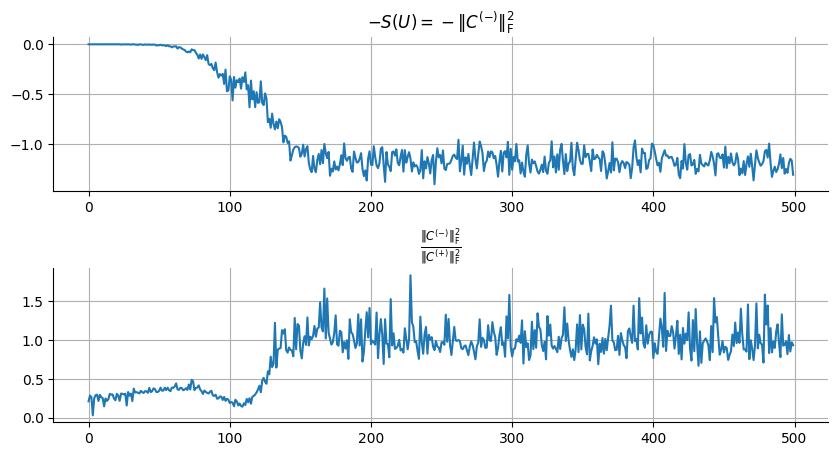

In [46]:
plt.figure(figsize=(10,5))
plt.subplot(211)
plt.plot(ls_loss)
plt.grid()
plt.title(r"$-S(U) = -\|C^{(-)}\|_\mathrm{F}^2$")
plt.gca().spines[['top','right']].set_visible(False)
plt.subplot(212)
plt.plot(ls_S_ratio)
plt.title(r"$\frac{\|C^{(-)}\|_\mathrm{F}^2}{\|C^{(+)}\|_\mathrm{F}^2}$")
plt.gca().spines[['top','right']].set_visible(False)
plt.grid()
plt.subplots_adjust(hspace=0.5)

Text(0.5, 1.0, 's = 0.993751585483551')

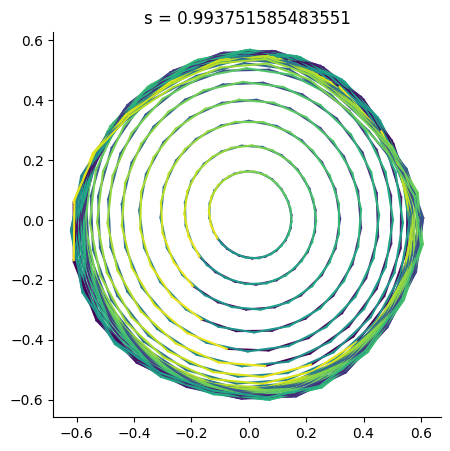

In [50]:
alpha_tilde, l, sigma_f = get_params(params)

d = 2
alpha, K_A_u, K_u_u, H_K_A_u = get_alpha(params, A, X, u, kernel_function=K_X_Y_squared_exponential)

alpha_reshaped = alpha.reshape(K,T,d)                                           #(K, T, d)
mean = jnp.mean(alpha_reshaped, axis=(0), keepdims=True)                        #(1, T, d)
optimized_alpha_H = (alpha_reshaped - mean).reshape(K*T,d)                      #(K*T,d)

K_A_X = jnp.zeros((K*T, K, T))
for k in range(K):
    K_u_X = K_X_Y_squared_exponential(u, X[k], l=l, sigma_f=sigma_f)
    K_A_X = K_A_X.at[:, k, :].set( jnp.einsum('kc,cj,jm ->km',  K_A_u, jnp.linalg.inv(K_u_u), K_u_X) )

projection = jnp.einsum('ij,imk->mjk', optimized_alpha_H, K_A_X)                #(K*T,d) @ (K*T, K, T) --> (K, d, T)


projection, _ = pre_processing(projection, pca=False, soft_normalize=None)
plot_2D(projection[:,:,:])
#plt.title(f's = {compute_S_all_pairs(projection)}')
plt.title(f's = {np.mean(compute_S(projection))}')
# plt.figure()
# plt.plot(projection[0,0,:])
# plt.plot(projection[0,1,:])

In [48]:
print(l)
print(sigma_f)

1.1737638
1


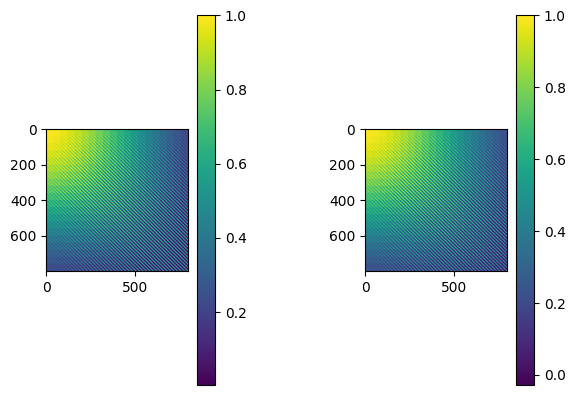

In [51]:
K_A_u =  K_X_Y_squared_exponential(A, u, l = l, sigma_f=sigma_f)    
K_A_A_low_rank = jnp.einsum('kc,cj,mj ->km',  K_A_u, jnp.linalg.inv(K_u_u), K_A_u)
K_A_A_exact = K_X_Y_squared_exponential(A, A ,l=l, sigma_f=sigma_f)
# K_A_A_reshaped = K_A_A_exact.reshape(K,T,K,T)   
# means = jnp.mean(K_A_A_reshaped, axis=(0, 2), keepdims=True)     #(1, T, 1, T)
# K_A_A_tilde_exact = (K_A_A_reshaped - means).reshape(K*T,K*T)          #(K*T,K*T)

plt.subplot(121)
plt.imshow(K_A_A_exact)
plt.colorbar()
plt.subplot(122)
plt.imshow(K_A_A_low_rank)
plt.colorbar()
#nmse = jnp.mean( (K_A_A_tilde_exact - K_A_A_low_rank)**2) / jnp.mean(K_A_A_exact**2)
#plt.suptitle(f' NMSE = {nmse}' )
plt.subplots_adjust(wspace=0.8)


# K_A_X_exact = np.zeros((K*T, K, T))
# for k in range(K):
#     K_A_X_exact[:,k,:] = K_X_Y_squared_exponential(A, X[k]) # l=l, sigma_f=sigma_f

# plt.figure()
# plt.subplot(121)
# plt.imshow(K_A_X_exact[:,0,:],aspect='auto')
# plt.colorbar()
# plt.subplot(122)
# plt.imshow(K_A_X[:,0,:], aspect='auto')
# plt.colorbar()
# nmse = jnp.mean( (K_A_X_exact - K_A_X)**2) / jnp.mean(K_A_X_exact**2)
# plt.suptitle(f' NMSE = {nmse}' )
# plt.subplots_adjust(wspace=0.8)


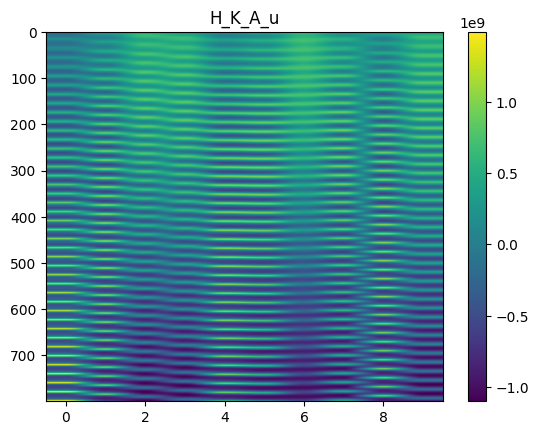

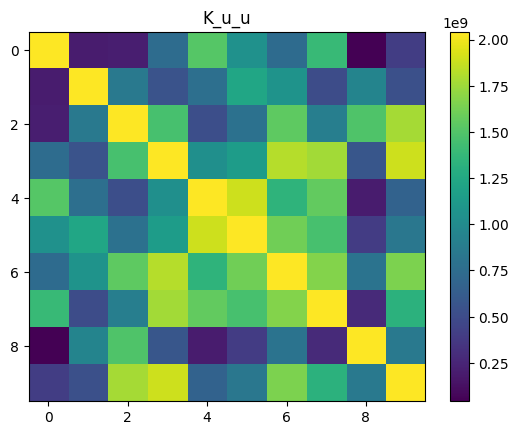

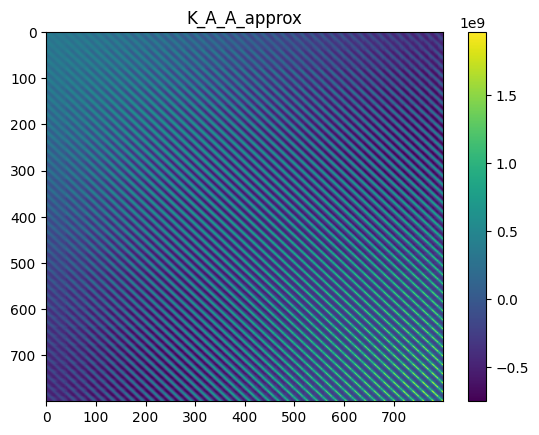

In [14]:
plt.imshow(H_K_A_u, aspect='auto')
plt.title('H_K_A_u')
plt.colorbar()

plt.figure()
plt.imshow( K_u_u , aspect='auto' )
plt.title('K_u_u')
plt.colorbar()

plt.figure()
plt.imshow( H_K_A_u @ jnp.linalg.inv(K_u_u) @ H_K_A_u.T, aspect='auto' )
plt.title('K_A_A_approx')
plt.colorbar()

ENDS HERE

In [ ]:
    #SVD
    # K_A_A = kernel_function(A, A, l=l, sigma_f=sigma_f)
    # K_A_A_reshaped = K_A_A.reshape(K,T,K,T)                          #(K,T,K,T)
    # means = jnp.mean(K_A_A_reshaped, axis=(0, 2), keepdims=True)     #(1, T, 1, T)
    # K_A_A_tilde = (K_A_A_reshaped - means).reshape(K*T,K*T)          #(K*T,K*T)
    # P, S, _ = jnp.linalg.svd(K_A_A_tilde, full_matrices=False)
    # # num_components = 10
    # # P = P[:, :num_components]
    # # S = S[:num_components]
    
    # alpha_tilde_QR, _ = jnp.linalg.qr(alpha_tilde) 
    # alpha = (P / jnp.sqrt(S+1e-1)) @ alpha_tilde_QR

    #QR
    # K_A_A = kernel_function(A, A, l=l, sigma_f=sigma_f)
    # K_A_A_reshaped = K_A_A.reshape(K,T,K,T)                          #(K,T,K,T)
    # means = jnp.mean(K_A_A_reshaped, axis=(0, 2), keepdims=True)     #(1, T, 1, T)
    # K_A_A_tilde = (K_A_A_reshaped - means).reshape(K*T,K*T)          #(K*T,K*T)
    # Q, R = jnp.linalg.qr(K_A_A_tilde)                                #Q and R are (K*T, K*T)
    # alpha_tilde_QR, _ = jnp.linalg.qr(alpha_tilde) 
    # #alpha = Q @ jnp.linalg.inv(R.T) @ alpha_tilde_QR                 #Q @ triangular_solve(R.T, alpha_tilde_QR, lower=True)
    # R_inv_transpose = triangular_solve(R.T, jnp.eye(R.shape[0]), lower=True)
    # alpha = Q @ R_inv_transpose @ alpha_tilde_QR


    #QR
    # K_A_A = kernel_function(A, A, l=l, sigma_f=sigma_f)
    # K_A_A_reshaped = K_A_A.reshape(K,T,K,T)                          #(K,T,K,T)
    # means = jnp.mean(K_A_A_reshaped, axis=(0, 2), keepdims=True)     #(1, T, 1, T)
    # K_A_A_tilde = (K_A_A_reshaped - means).reshape(K*T,K*T)          #(K*T,K*T)
    # Q, R = jnp.linalg.qr(K_A_A_tilde)                                #Q and R are (K*T, K*T)
    # #Q_truncated = Q[:, :c]
    # #R_truncated = R[:c, :]
    # alpha_tilde_QR, _ = jnp.linalg.qr(alpha_tilde) 
    # alpha = Q @ jnp.linalg.inv(R.T) @ alpha_tilde_QR
    # H_K_A_u = None
    # K_A_u = None 
    # K_u_u = None

In [ ]:
# K_A_A = K_X_Y_squared_exponential(A, A)
# K_A_A_reshaped = K_A_A.reshape(K,T,K,T)                          #(K,T,K,T)
# means = jnp.mean(K_A_A_reshaped, axis=(0, 2), keepdims=True)     #(1, T, 1, T)
# K_A_A_tilde = (K_A_A_reshaped - means).reshape(K*T,K*T)          #(K*T,K*T)
# Q, R = jnp.linalg.qr(K_A_A) 

# alpha_tilde = random.normal(key, (K*T, 3))
# alpha_tilde_QR, _ = jnp.linalg.qr(alpha_tilde) 
# alpha = Q @ jnp.linalg.inv(R.T) @ alpha_tilde_QR                 #Q @ triangular_solve(R.T, alpha_tilde_QR, lower=True)



# K_A_A = K_X_Y_squared_exponential(A, A)
# K_A_A_reshaped = K_A_A.reshape(K,T,K,T)                          #(K,T,K,T)
# means = jnp.mean(K_A_A_reshaped, axis=(0, 2), keepdims=True)     #(1, T, 1, T)
# K_A_A_tilde = (K_A_A_reshaped - means).reshape(K*T,K*T)          #(K*T,K*T)
# P, S, _ = jnp.linalg.svd(K_A_A_tilde, full_matrices=False)
# num_components = 10
# P = P[:, :num_components]
# S = S[:num_components]

In [ ]:
K_A_u =  K_X_Y_squared_exponential(A, u)               #(K*T, c)
K_u_u =  K_X_Y_squared_exponential(u, u)               #(c, c)
K_A_A = K_A_u @ K_u_u @ K_A_u.T
L = jnp.linalg.cholesky(K_u_u + jnp.identity(c) * 1e-6)
jnp.allclose(K_u_u, L @ L.T)

alpha_tilde = random.normal(key, (c, 3))
Q, R = jnp.linalg.qr(K_A_u, mode='reduced') 
alpha_tilde_QR, _ = jnp.linalg.qr(alpha_tilde) 
#L_alpha = jnp.dot(L, alpha_tilde_QR)
#alpha = Q @ triangular_solve(R.T, L_alpha, lower=True)
#Q @ jnp.linalg.inv(R.T) @ L @ alpha_tilde_QR                               #(K*T, c) @ (c, c) @ (c, c) @ (c, d)
#R_inv_transpose = triangular_solve(R.T, jnp.eye(R.shape[0]), lower=True)

alpha = jnp.einsum('kc, cl, lj, jd -> kd', Q, triangular_solve(R.T, jnp.eye(R.shape[0]), lower=True), L, alpha_tilde_QR) 

# K_u_X_i =  K_X_Y_squared_exponential(u, X[0])                       #(c, K, T)
# K_X_u_i =  K_X_Y_squared_exponential(u, X[0]).T

# K_A_X_i = jnp.einsum('kc,cj,jm ->km',  K_A_u, K_u_u, K_u_X_i) 
# K_X_A_i = jnp.einsum('kc,cj,mj ->km',  K_X_u_i, K_u_u, K_A_u) 

In [ ]:
# K_u_X = jnp.zeros((c, K, T))
# for k in range(K):
#     K_u_X = K_u_X.at[:, k, :].set(K_X_Y_squared_exponential(u, X[k], l=l, sigma_f=sigma_f))


K_A_u =  K_X_Y_squared_exponential(A, u)               #(K*T, c)
K_u_u =  K_X_Y_squared_exponential(u, u)               #(c, c)
K_A_A = K_A_u @ K_u_u @ K_A_u.T
L = jnp.linalg.cholesky(K_u_u + jnp.identity(c) * 1e-6)
jnp.allclose(K_u_u, L @ L.T)

alpha_tilde = random.normal(key, (c, 3))
Q, R = jnp.linalg.qr(K_A_u, mode='reduced') 
alpha_tilde_QR, _ = jnp.linalg.qr(alpha_tilde) 

alpha = jnp.einsum('kc, cl, lj, jd -> kd', Q, triangular_solve(R.T, jnp.eye(R.shape[0]), lower=True), L, alpha_tilde_QR) 

K_A_A = jnp.einsum('kc,cj,mj ->km',  K_A_u, K_u_u, K_A_u)
# K_u_X_i =  K_X_Y_squared_exponential(u, X[0])                       #(c, K, T)
# K_X_u_i =  K_X_Y_squared_exponential(u, X[0]).T

# K_A_X_i = jnp.einsum('kc,cj,jm ->km',  K_A_u, K_u_u, K_u_X_i) 
# K_X_A_i = jnp.einsum('kc,cj,mj ->km',  K_X_u_i, K_u_u, K_A_u) 


# delta_xz = jnp.eye(len(X))  # Assuming X and Z are the same for simplification of the Kronecker delta
# k_fitc = K_A_A + jnp.eye(K_A_A.shape[0]) * (K_X_Y_squared_exponential(A, A) - K_A_A)

In [ ]:
def kernel(X1, X2, l=1.0, sigma_f=1.0):
    sqdist = np.sum(X1**2, 1).reshape(-1, 1) + np.sum(X2**2, 1) - 2 * np.dot(X1, X2.T)
    return sigma_f**2 * np.exp(-0.5 / l**2 * sqdist)
print( kernel(A.T,A.T, l=5,  sigma_f=10) )